In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={'figure.figsize':(12,6)}, style='whitegrid')

In [2]:
# Loading and reading dataset
df_bicycle = pd.read_csv('data\london.csv')
df_bicycle

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [3]:
# Investigating dataset information
def overview(df):
    print(" DATA INFO ".center(125,'-'))
    print(df.info())
    
    print(" SHAPE OF DATASET ".center(125,'-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns:{}'.format(df.shape[1]))
    
    print(" DATA TYPES ".center(125,'-'))
    print(df.dtypes)
    
    print(" STATISTICS OF DATA ".center(125,'-'))
    print(df.describe(include="all"))
    
    print(" MISSING VALUES ".center(125,'-'))
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))
    
    print(" DUPLICATED VALUES ".center(125,'-'))
    print(df.duplicated().sum())

overview(df_bicycle)

--------------------------------------------------------- DATA INFO ---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB
None
------------------------------------------------------ SHAPE OF DATASET -----------------------------------------------------
Rows:17414
Columns:10
----------------------------------

Data description:

    timestamp - date and time (accurate to the hour)
    cnt - number of bicycle rentals for this hour
    t1 - temperature, in C
    t2 - temperature "feels like", in C 
    hum - humidity (%)
    wind_speed - wind speed, km/h
    weather_code - weather conditions
        1 - clear (SKC)
        2 - mostly clear / isolated clouds occur (SCT)
        3 - cloudy / significant clouds (BKN)
        4 - cloudy (OVC)
        7 - light rain Rain/ light Rain shower/ Light rain 
        10 - rain with thunderstorm
        26 - snowfall 
        94 - ice fog (yes, it happens!)
    isholiday - is the day a holiday (1 - holiday, 0 - not)
    isweekend - is the day a weekend (1 - weekend, 0 - no)
    season - weather season (0 - spring, 1 - summer, 2 - fall, 3 - winter)


<font color="red">REMARK:</font>
There are no missing values or duplicates in the dataset. Convert timestamp to date time type

In [4]:
df_bicycle.timestamp = pd.to_datetime(df_bicycle.timestamp)
df_bicycle.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

<Axes: xlabel='timestamp', ylabel='cnt'>

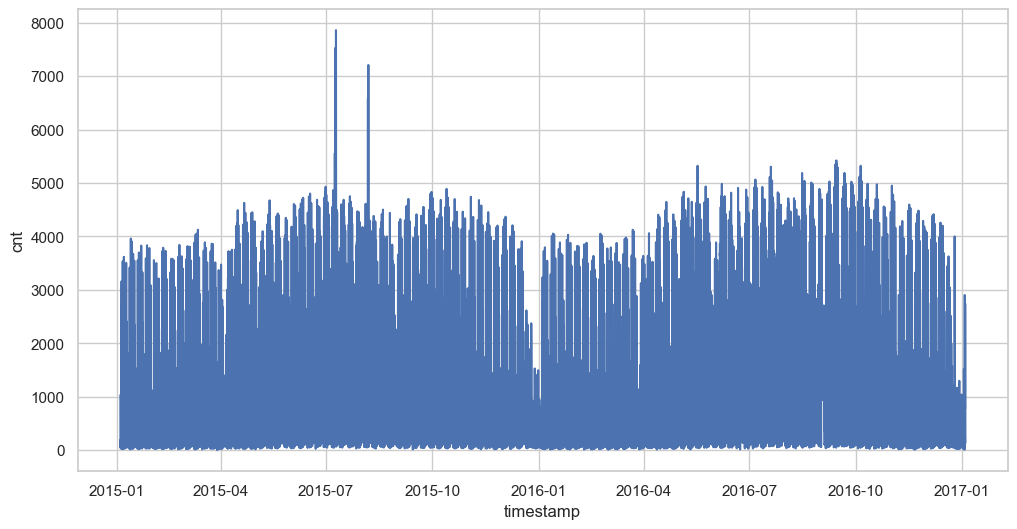

In [5]:
# Chart by number of trips by date and time
sns.lineplot(x=df_bicycle.timestamp, y=df_bicycle.cnt)

<font color="red">REMARK:</font>
It is very difficult to understand something from such a graph so you need to transform the data to see trends

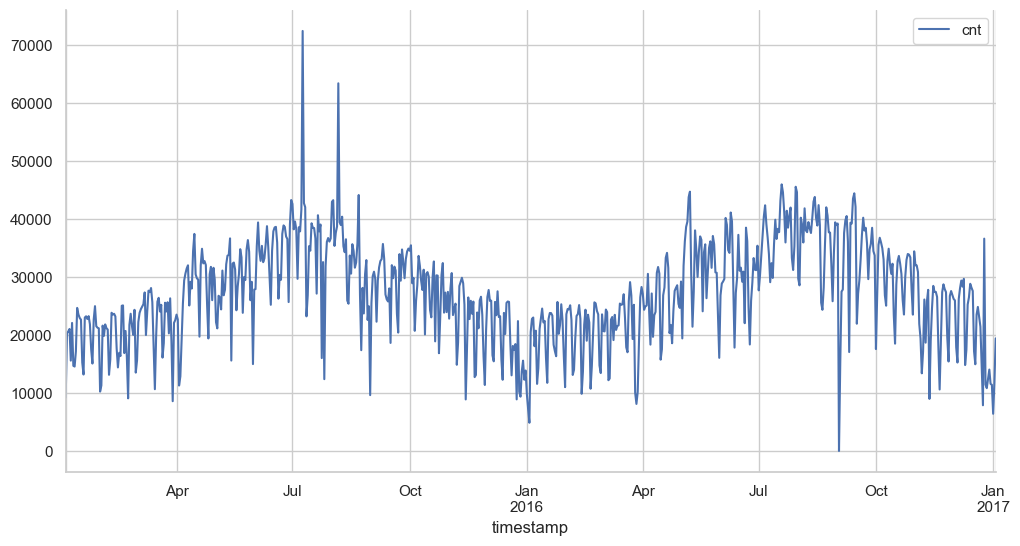

In [6]:
df_bicycle.sort_values(by='timestamp', inplace=True)
df_bicycle.set_index('timestamp', drop=False, inplace=True)
df_bicycle.resample('D').agg({'cnt': 'sum'}).plot()
sns.despine()

<Axes: xlabel='timestamp', ylabel='cnt'>

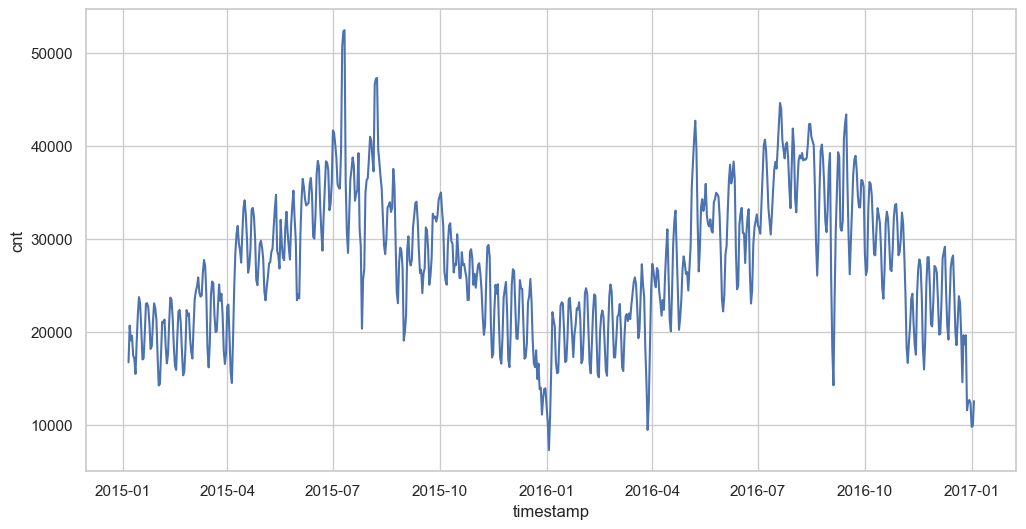

In [7]:
# Aggregate data by day and calculate moving average with window 3
df_by_day = (df_bicycle
                 .resample('D')
                 .cnt
                 .sum()
                 .reset_index()
            )
df_by_day_rolling = (df_bicycle
                         .resample('D')
                         .cnt
                         .sum()
                         .rolling(window=3).mean()
                         .reset_index()
                    )

sns.lineplot(df_by_day_rolling, x='timestamp', y='cnt')

In [8]:
# Calculation of the standard deviation and determination of the 99% confidence interval
std = np.std(df_by_day['cnt'] - df_by_day_rolling['cnt'])
lower_bound = df_by_day_rolling.cnt - (2.576 * std)
upper_bound = df_by_day_rolling.cnt + (2.576 * std)
df_by_day = df_by_day.assign(lower_bound=lower_bound, upper_bound=upper_bound)
df_by_day

,timestamp,cnt,lower_bound,upper_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,4996.747479,28482.585854
3,2015-01-07,21064,8940.080812,32425.919188
4,2015-01-08,15601,7349.747479,30835.585854
...,...,...,...,...
726,2016-12-30,11566,939.080812,24424.919188
727,2016-12-31,11424,604.414146,24090.252521
728,2017-01-01,6421,-1939.252521,21546.585854
729,2017-01-02,11823,-1853.585854,21632.252521


In [9]:
# Abnormally high value
index_of_max_difference = (df_by_day['cnt'] - df_by_day['upper_bound']).idxmax()
row_with_max_difference = df_by_day.loc[index_of_max_difference]
row_with_max_difference

timestamp      2015-07-09 00:00:00
cnt                          72504
lower_bound           38962.080812
upper_bound           62447.919188
Name: 186, dtype: object

The possible reason for this anomaly is the strike of subway workers, which caused heavy traffic jams
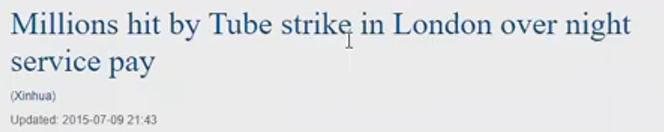

In [10]:
# Abnormally low value
index_of_min_difference = (df_by_day['cnt'] - df_by_day['lower_bound']).idxmin()
row_with_min_difference = df_by_day.loc[index_of_min_difference]
row_with_min_difference

timestamp      2016-09-02 00:00:00
cnt                              0
lower_bound           14343.414146
upper_bound           37829.252521
Name: 607, dtype: object

A possible reason for a value of 0 is that there were no bicycle rental data records on that day or unformed data in the initial dataset